# Setup

## Imports

In [86]:
# Setup
import os
import joblib
import pickle
import json
from utils.custom_transformers import ColumnSelector, CategoricalTransformer, SaveTransformer, NumericalTransformer

# Data Analysis
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt

#Scikit learn
from lightgbm import LGBMClassifier
from category_encoders import TargetEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix,roc_auc_score,roc_curve,classification_report,auc, plot_confusion_matrix 
from xgboost import XGBClassifier



## Configs

In [2]:
%matplotlib inline
pd.set_option('display.max_columns', None)
seed = 42

## Functions

In [3]:
def load_data(file_name, folder = "data"):
    df = pd.read_csv(os.path.join(folder, file_name))
    return df

def target_transformation(text):
    text = text.replace(" ", "").lower()
    if text == "yes" :
        return 1
    elif text == "no":
        return 0

# Data Analysis

## Data Load

In [4]:
df_original = load_data("train_data.csv","data")

In [89]:
df_original['readmitted'].value_counts()

No     72340
Yes     9072
Name: readmitted, dtype: int64

# Pipelines

## Custom Transformers

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df_original.drop(columns=['readmitted']), 
                                                    df_original['readmitted'],
                                                    shuffle = False,
                                                    test_size=0.3, 
                                                    random_state=seed)

In [6]:
y_train = y_train.apply(target_transformation)
y_test = y_test.apply(target_transformation)

In [104]:
categorical = ['admission_source_code','discharge_disposition_code','admission_type_code','medical_specialty','insulin','change','gender','diag_1','A1Cresult','max_glu_serum','diabetesMed','has_prosthesis','blood_transfusion','diuretics','payer_code','complete_vaccination_status','blood_type','age']
numerical = ['num_medications','hemoglobin_level','time_in_hospital','num_lab_procedures','num_procedures','number_outpatient','number_emergency','number_inpatient','number_diagnoses']
#excluding = ['diag_2','diag_3','weight','race']

cat_pipe = Pipeline([
    ('selector', ColumnSelector(categorical))
    ,('transformer',CategoricalTransformer(mininum_records=100))
    ,('imputer', SimpleImputer(strategy='constant', fill_value='missing'))
    ,('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

num_pipe = Pipeline([
    ('selector', ColumnSelector(numerical))
    ,('transformer',NumericalTransformer())
    ,('imputer', SimpleImputer(strategy='median'))
    ,('scaler', RobustScaler())
])

pre_processor = FeatureUnion([
    ('cat', cat_pipe)
    ,('num', num_pipe)
])

pipeline = Pipeline([
    ('preprocessor', pre_processor)
    ,('model', LGBMClassifier())
])

pipeline.fit(X_train, y_train)

# Predict training data
y_train_pred = pipeline.predict(X_train)
print(f"Predictions on training data: {y_train_pred}")

# Predict test data
y_test_pred = pipeline.predict(X_test)
print(f"Predictions on test data: {y_test_pred}")        

Predictions on training data: [0 0 0 ... 0 0 0]
Predictions on test data: [0 0 0 ... 0 0 0]


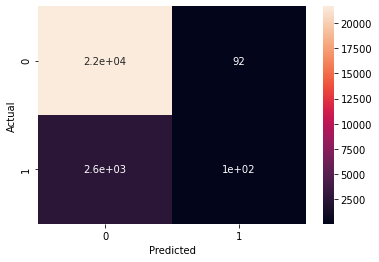

In [109]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

data = {'y_Actual':    y_test,
        'y_Predicted': [1 if i >= 0.42 else 0 for i in pipeline.predict_proba(X_test)[:,1]]  
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, annot=True)
plt.show()

/Users/tiagosousa/.virtualenvs/capstone-project/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


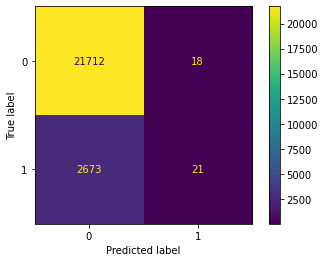

In [49]:
plot_confusion_matrix(pipeline, X_test, y_test)  
plt.show()

ROC-AUC:


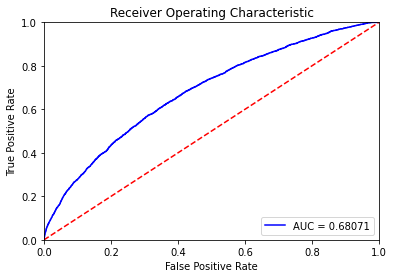

In [111]:
y_scores = pipeline.predict_proba(X_test)[:,1]
fpr, tpr, threshold = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)
print("ROC-AUC:")
plt.title("Receiver Operating Characteristic")
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [110]:
precision, recall, fscore, support = precision_recall_fscore_support(y_test, [1 if i >= 0.42 else 0 for i in pipeline.predict_proba(X_test)[:,1]] )
precision, recall, fscore, support

(array([0.89298832, 0.52331606]),
 array([0.99576622, 0.03749072]),
 array([0.94158091, 0.06996883]),
 array([21730,  2694]))

In [114]:
for a in np.linspace(0,1,20):
    y_scores_treshold = [1 if x > a else 0 for x in y_scores]
    fpr, tpr, thresholds = roc_curve(y_test, y_scores_treshold, pos_label=1)
    print("With treshold = {} AUC of {}".format(a,auc(fpr, tpr)))

With treshold = 0.0 AUC of 0.5
With treshold = 0.05263157894736842 AUC of 0.5501410131973321
With treshold = 0.10526315789473684 AUC of 0.6294211950607971
With treshold = 0.15789473684210525 AUC of 0.6069768478707604
With treshold = 0.21052631578947367 AUC of 0.5720480411720955
With treshold = 0.2631578947368421 AUC of 0.5446574532350357
With treshold = 0.3157894736842105 AUC of 0.5327965436648945
With treshold = 0.3684210526315789 AUC of 0.5242531766831304
With treshold = 0.42105263157894735 AUC of 0.5166514806300309
With treshold = 0.47368421052631576 AUC of 0.5104716178270746
With treshold = 0.5263157894736842 AUC of 0.5063608994916693
With treshold = 0.5789473684210527 AUC of 0.5024372990924935
With treshold = 0.631578947368421 AUC of 0.5007193808333428
With treshold = 0.6842105263157894 AUC of 0.5001855976243504
With treshold = 0.7368421052631579 AUC of 0.5001855976243504
With treshold = 0.7894736842105263 AUC of 0.5001855976243504
With treshold = 0.8421052631578947 AUC of 0.5
Wit

# Model


In [ ]:
TMP_DIR = '/tmp'

In [115]:
with open("columns.json", 'w') as fh:
    json.dump(df_original.columns.tolist(), fh)

with open("dtypes.pickle", 'wb') as fh:
    pickle.dump(df_original.dtypes, fh)
    
joblib.dump(pipeline, 'pipeline.pickle') 

['pipeline.pickle']